In [2]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import cmb_anomaly_utils as cau

plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('legend', facecolor='white', edgecolor='k', framealpha=1)
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['ytick.major.size'] = 3.5
plt.rcParams['xtick.labelsize']  = 12
plt.rcParams['ytick.labelsize']  = 12

#### Run Parameters

In [3]:
max_sim_num                     = 1000
base_path                       = "./output/"
run_inputs  = cau.run_utils.RunInputs()
run_inputs.mask_fpath           = "./input/cmb_fits_files/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
run_inputs.cmb_fpath            = "./input/cmb_fits_files/COM_CMB_IQU-commander_2048_R3.00_full.fits"
run_inputs.cmb_dir_anom_fpath   = "./output/cmb_inpainted_all_dir_cap_anom.txt"
run_inputs.sims_path            = "./input/commander_sims/"
run_inputs.noise_path           = "./input/commander_noise/"
run_inputs.sims_dir_anom_path   = "./output/sims_inpainted_all_dir_cap_anom_5deg/"
run_inputs.geom_flag            = cau.const.CAP_FLAG
run_inputs.measure_flag         = cau.const.STD_FLAG
run_inputs.is_masked            = True
run_inputs.min_pix_ratio        = 0.1
run_inputs.nside                = 64
run_inputs.dir_nside            = 16
run_inputs.geom_start           = 0
run_inputs.geom_stop            = 180
run_inputs.delta_geom_samples   = 5
run_inputs.stripe_thickness     = 20

measure_map_nside               = 16
all_disc_sizes = np.array([6])
# np.array([1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 40, 45, 50, 55, 60, 70, 75, 80, 85, 90])

#### Compute Measure Map

In [4]:
print("Warming Up!")
map_gen = cau.run_utils.MapGenerator(**run_inputs.to_kwargs())

dummy_map = map_gen.create_dummy_map()
dir_lat, dir_lon = cau.coords.get_healpix_latlon(measure_map_nside)
ndir = cau.coords.get_npix(measure_map_nside)
measure_pix_indices = np.arange(ndir, dtype=int)

cmb_measure = np.zeros(ndir)
sim_measure = np.zeros((max_sim_num, ndir))

print("Reading CMB Data:")
cmb_map = map_gen.create_cmb_map()
cau.map_utils.remove_monopole_dipole(cmb_map)
print("\t-Done-")

print("Providing Simulations:")
sim_maps = []
for sim_num in range(max_sim_num):
    print("\t{:04}/{:04}\r".format(sim_num+1, max_sim_num), end="")
    sim_pix_map = map_gen.create_sim_map_from_txt(sim_num, use_noise=True)
    cau.map_utils.remove_monopole_dipole(sim_pix_map)
    sim_maps.append(sim_pix_map)
print("")

Warming Up!
Reading CMB Data:
	-Done-
Providing Simulations:
	1000/1000


In [5]:
for disc_size in all_disc_sizes:
    print("Disc Size(deg): {:2}".format(disc_size))
    print("Computing Map Pixels:")
    for dir_i in measure_pix_indices:
        print(f"\t{dir_i}/{ndir - 1}\r", end="")
        plat, plon = dir_lat[dir_i], dir_lon[dir_i]
        dummy_map.change_pole(plat, plon)
        top_filter, bottom_filter = cau.geometry.get_top_bottom_caps_selection_filters( pix_map = dummy_map,
                                                                                        cap_angle = disc_size)
        # CMB measure
        top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters(pix_map = cmb_map,
                                                                        top_sel = top_filter,
                                                                        bottom_sel = bottom_filter)
        visible_ratio = top_cap.get_visible_pixels_ratio()
        cmb_measure[dir_i] = \
            np.nan if visible_ratio < run_inputs.min_pix_ratio else \
                cau.measure.calc_var(top_cap, **run_inputs.to_kwargs())
        # Simulation Measure
        for sim_num in range(max_sim_num):
            top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters(  pix_map = sim_maps[sim_num],
                                                                                top_sel = top_filter,
                                                                                bottom_sel = bottom_filter)
            sim_measure[sim_num, dir_i] = \
                np.nan if visible_ratio < run_inputs.min_pix_ratio else \
                    cau.measure.calc_var(top_cap, **run_inputs.to_kwargs())
    print("")

    np.savetxt("./output/akrami_2014/sim_var_map_{:02}disc.txt".format(disc_size), sim_measure)
    np.savetxt("./output/akrami_2014/cmb_var_map_{:02}disc.txt".format(disc_size), cmb_measure)

# print("-Done-")

Disc Size(deg): 25
Computing Map Pixels:
	3071/3071
Disc Size(deg): 30
Computing Map Pixels:
	3071/3071
Disc Size(deg): 40
Computing Map Pixels:
	3071/3071
Disc Size(deg): 45
Computing Map Pixels:
	3071/3071
Disc Size(deg): 50
Computing Map Pixels:
	3071/3071
Disc Size(deg): 55
Computing Map Pixels:
	3071/3071
Disc Size(deg): 60
Computing Map Pixels:
	3071/3071
Disc Size(deg): 70
Computing Map Pixels:
	3071/3071
Disc Size(deg): 75
Computing Map Pixels:
	3071/3071
Disc Size(deg): 80
Computing Map Pixels:
	3071/3071
Disc Size(deg): 85
Computing Map Pixels:
	3071/3071
Disc Size(deg): 90
Computing Map Pixels:
	3071/3071


#### Fitting Dipole

In [6]:
def get_dipole_amplitude(var_map, mean_field, var_var):
    res = hp.fit_dipole((var_map - mean_field) / var_var)
    # direction = hp.vec2ang(res[1], lonlat=True)
    amplitude = np.sqrt(np.dot(res[1], res[1]))
    return amplitude

In [8]:
measure_path = "./output/akrami_2014/"
fnames = os.listdir(measure_path)
sim_fnames = [f_n for f_n in fnames if "sim" in f_n.lower()]
cmb_fnames = [f_n for f_n in fnames if "cmb" in f_n.lower()]

cmb_amplitudes = []
sims_amplitudes = []
for disc_size in all_disc_sizes:
    # Read Var Maps
    disc_size_str = str(int(disc_size))
    cmb_f_n = [f_n for f_n in cmb_fnames if disc_size_str in f_n][0]
    cmb_var_map = np.loadtxt(measure_path + cmb_f_n)
    sims_f_n = [f_n for f_n in sim_fnames if disc_size_str in f_n][0]
    all_sims_var_maps = np.loadtxt(measure_path + sims_f_n)
    # Find Mean Field
    mean_field = np.mean(all_sims_var_maps, axis = 0)
    var_var = np.var(all_sims_var_maps, axis = 0)
    # Read Amplitudes
    cmb_amp = get_dipole_amplitude(cmb_var_map, mean_field, var_var)
    cmb_amplitudes.append(cmb_amp)
    sims_amps = [get_dipole_amplitude(sim_var_map, mean_field, var_var) \
                    for sim_var_map in all_sims_var_maps]
    sims_amplitudes.append(sims_amps)

cmb_amplitudes = np.array(cmb_amplitudes)
sims_amplitudes = np.array(sims_amplitudes)

/tmp/ipykernel_476/322333038.py:2: RuntimeWarning: invalid value encountered in divide
  res = hp.fit_dipole((var_map - mean_field) / var_var)


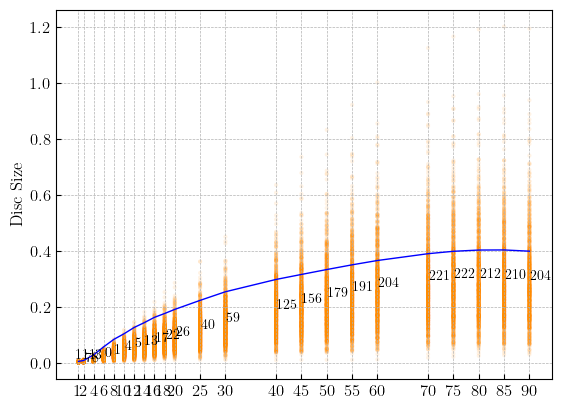

In [11]:
all_p_values = []
with plt.style.context('bmh'):
    fig, ax=plt.subplots()
    for i, disc_size in enumerate(all_disc_sizes):
        sims_amps = sims_amplitudes[i]
        p_value = np.sum(sims_amps > cmb_amplitudes[i])# / len(sims_amps)
        all_p_values.append(p_value)
        ax.scatter(
            disc_size * np.ones(max_sim_num), sims_amps,
            marker = '.', edgecolors = 'none', linewidths = 1,
            c = 'darkorange', alpha = 0.1)
        if disc_size == 1:
            ax.text(x=disc_size - 0.5, y = np.mean(sims_amps) + .01, s = str(p_value))
        else:
            ax.text(x=disc_size + 0.2, y = np.mean(sims_amps), s = str(p_value))
    ax.plot(all_disc_sizes, cmb_amplitudes, color='b', linewidth=1, label = r'CMB')
    ax.set_ylabel(r"Dipole Amplitude")
    ax.set_ylabel(r"Disc Size")
    ax.set_xticks(all_disc_sizes)
    ax.set_facecolor('white')
    for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
plt.show()

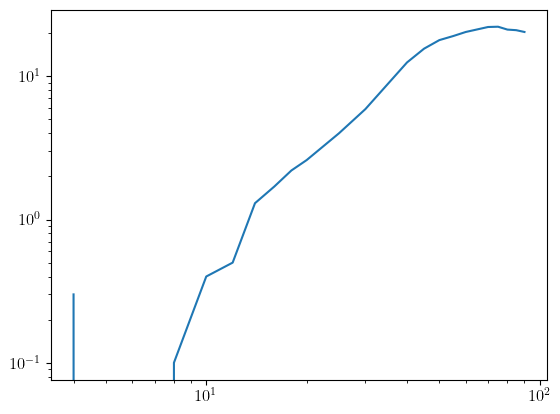

In [17]:
p_values    = np.array(all_p_values)
angles      = all_disc_sizes

# for i in range(len(p_values)):

plt.plot(angles[2:], p_values[2:] / 1000 * 100)
plt.yscale("log")
plt.xscale("log")
plt.show()

#### Noise check

In [6]:
fnames = os.listdir(run_inputs.noise_path)
for i, f_n in enumerate(fnames):
    noise_map = np.loadtxt(run_inputs.noise_path + f_n)
    hp.mollview(noise_map)
    plt.savefig("./output/plots/noise_check/{:03}.jpg".format(i))


/home/jam3d/.local/lib/python3.10/site-packages/healpy/visufunc.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = pylab.figure(fig, figsize=(8.5, 5.4))


#### Plot

In [4]:
sim_measure = np.loadtxt("./output/akrami_2014/sim_measure.txt")
cmb_measure = np.loadtxt("./output/akrami_2014/cmb_measure.txt")

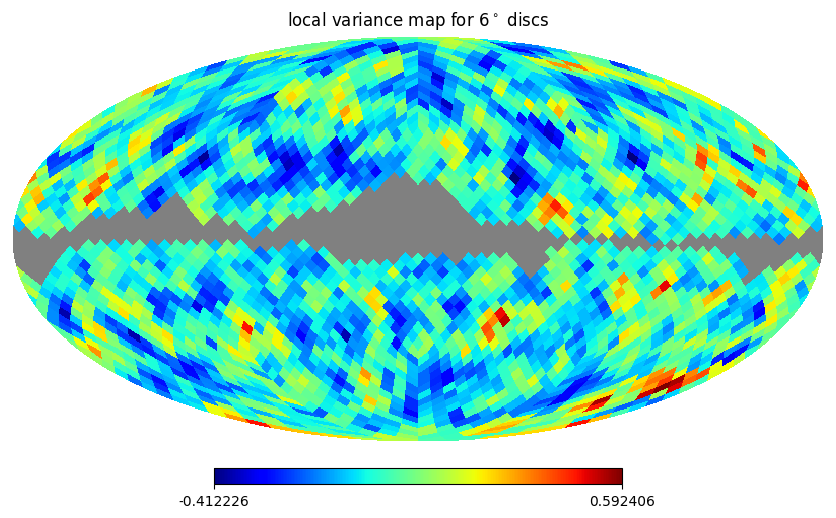

In [5]:
var_var = np.var(sim_measure, axis=0)
mean_var = np.mean(sim_measure, axis=0)
cmb_var = cmb_measure
hp.mollview((cmb_var - mean_var) / var_var,
            # min = -0.5,
            # max = 0.5,
            title = r"local variance map for {}$^\circ$ discs".format(disc_size),
            cmap = "jet")
# hp.mollview((cmb_measure**2 - mean_std**2), cmap="jet")

#### Dipole Amplitude

In [8]:
res = hp.fit_dipole((cmb_var - mean_var)/var_var)
direction = hp.vec2ang(res[1], lonlat=True)
amplitude = np.sqrt(np.dot(res[1], res[1]))
print("Amplitude:", amplitude)
print("Direction(lonlat):", direction[0], direction[1])

Amplitude: 0.05695319162401411
Direction(lonlat): [211.42153332] [-16.20578391]


#### Test Dipole Addition

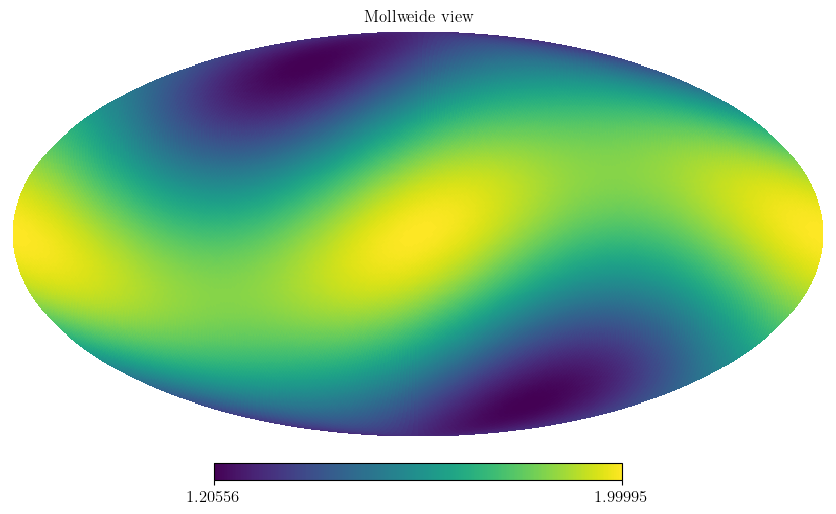

In [80]:
nside = 64
_map = np.zeros(12 * nside * nside)
_pos = cau.coords.get_healpix_xyz(nside)

_map = np.cos(_pos[:, 2])

_map = cau.coords.rotate_pixels_north_to_pole(_map, 45, 90)

hp.mollview(_map + np.cos(_pos[:, 2]))


#### Multipole Checking

10
[ 3.53803539e-04+0.00000000e+00j -4.77485997e-04+0.00000000e+00j
  1.39981185e+01+0.00000000e+00j -6.54900513e+00+0.00000000e+00j
  1.25279904e-04-1.39491102e-05j -2.83097220e+00+8.23349834e+00j
 -9.69152131e+00+1.07906936e+00j -1.25415117e+01-1.50623735e+01j
  2.11553644e+01+1.89788375e+00j -1.29061660e+01+3.01849906e+01j]
0 [0.0003538+0.j]
1 [-4.77485997e-04+0.j  1.39981185e+01+0.j]
2 [-6.54900513e+00+0.00000000e+00j  1.25279904e-04-1.39491102e-05j
 -2.83097220e+00+8.23349834e+00j]
3 [ -9.69152131 +1.07906936j -12.54151174-15.06237355j
  21.15536443 +1.89788375j -12.906166  +30.18499061j]


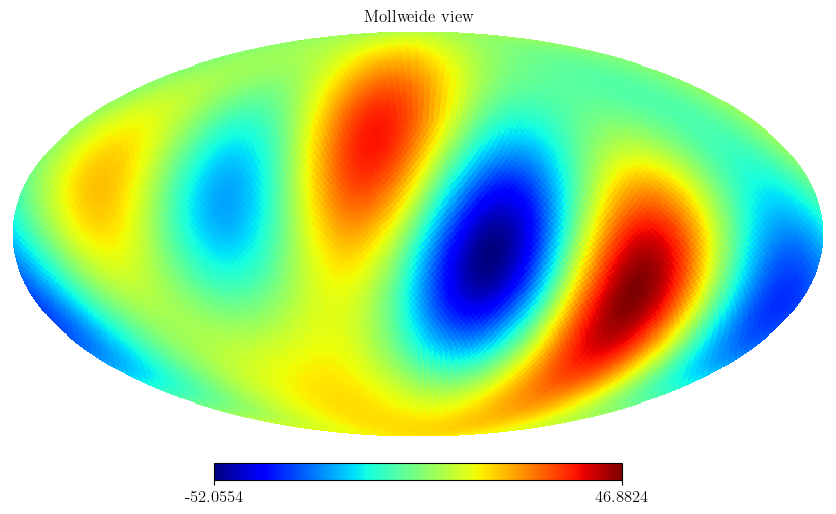

In [64]:
def purify_alm(alm_flat_list, non_zero_l = None):
    alm_list = []
    lmax = round(np.sqrt(len(alm_flat_list)))
    last_index = 0
    for l in range(lmax + 1):
        _len = l + 1
        same_l_alm = alm_flat_list[last_index: last_index + _len]
        alm_list.append(same_l_alm)
        last_index += _len
        print(l, same_l_alm)
    return alm_list

alm_flat_list = hp.sphtfunc.map2alm(cmb_map.raw_data, lmax = 3)
print(len(alm_flat_list))
print(alm_flat_list)
alm_list = purify_alm(alm_flat_list)

pure_alm_list = np.array([alm for same_l_alm in alm_list for alm in same_l_alm])

_map = hp.sphtfunc.alm2map(alm_flat_list, 32)
hp.mollview(_map, cmap='jet')

In [19]:
alm_list[2]

[(15.610981265434184+0j),
 (0.00012527990352462215-1.394911016847078e-05j),
 (-2.8309557249663104+8.233481995305684j),
 (-9.691521306886644+1.0790693573575851j),
 (-9.633928856319532+9.554971712100704j)]